- Orlando Cabrera #19943
- Diana Zaray Corado #191025
- Pablo Méndez #19195

# Laboratorio 5 - Análisis de Sentimientos

Utilice el dataset  *Natural Language Processing with Disaster Tweets*  de Kaggle.  Debe hacer un análisis exploratorio para entender mejor los datos, sabiendo que el objetivo final es clasificar si un tweet se refiere a un desastre real o no. Genere un informe en pdf con las explicaciones de los pasos que llevó a cabo y los resultados obtenidos. Recuerde que la investigación debe ser reproducible por lo que debe guardar el código que ha utilizado para resolver los ejercicios y/o cada uno de los pasos llevados a cabo si utiliza una herramienta visual.

In [106]:
from textblob import TextBlob
import pandas as pd
import re
import nltk
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [108]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
sns.set_theme(style="whitegrid", palette='Set2')
plt.rcParams['figure.figsize']=(25,10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...


# Descripción de los datos
El conjunto de datos se obtuvo mediante Kaggle en *Natural Language Processing with Disaster Tweets*. Posee un total de 7613 observaciones, y en cada una presenta la siguiente información:
- id: identificador del tweet
- keyword: palabra clave del tweet (puede ser NA)
- location: ubicación desde dónde fue enviado el tweet
- text: texto del tweet
- target: clasificación, donde 1 indica que el tweet es sobre un desastre real y 0 sobre un desastre falso.

In [22]:
data = pd.read_csv("train.csv")
display(data)
data.info()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Preprocesamiento
Limpie y preprocese los datos. Describa de forma detallada las actividades de preprocesamiento que llevó a cabo.

## Convertir el Texto a Minúsculas

In [23]:
data['text'] = data['text'].str.lower()
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


## Quitar URLs

In [24]:
expression = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"

data['text'] = data['text'].apply(lambda s: re.sub(expression, "", s))
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


## Remover caracteres especiales

Se eliminarán todas las palabras que empiezan con '@', ya que hacen referencia a un usuario. Esto es para evitar que la red neuronal sea afectada por nombres de usuarios complejos, como *@wildifires_are_bad*.

In [25]:
expression = r"\B@\w*"
data['text'] = data['text'].apply(lambda s: re.sub(expression, "", s))
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


De igual forma, para facilitar el aprendizaje del modelo, se removerán todos los caracteres que no sean letras.

In [26]:
expression = "[^a-z ]"
data['text'] = data['text'].apply(lambda s: re.sub(expression, "", s))
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


## Quitar las "stopwords"
Los *stopwords* son palabras que no proporcionan mucho significado a una frase desde el punto de vista de ML. La librería nltk proporciona una lista de stopwords en diferentes idiomas.

In [27]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(s):
    words = [word for word in s.split(" ") if not word in stopwords]
    return " ".join(words)

data['text'] = data['text'].apply(remove_stopwords)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


# Análisis Exploratorio
Haga un análisis exploratorio de los datos para entenderlos mejor, documente todos los análisis

## Frecuencia de palabras
Obtenga la frecuencia de las palabras tanto de los tweets de desastres como de los que no. ¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación? ¿Vale la pena explorar bigramas o trigramas para analizar contexto?

In [56]:
real_disaster = data[data.target == 1].text
fake_disaster = data[data.target == 0].text

real_unigrams = real_disaster.apply(lambda s: TextBlob(s).ngrams(n=1))
fake_unigrams = fake_disaster.apply(lambda s: TextBlob(s).ngrams(n=1))
real_bigrams = real_disaster.apply(lambda s: TextBlob(s).ngrams(n=2))
fake_bigrams = fake_disaster.apply(lambda s: TextBlob(s).ngrams(n=2))
# Frecuencia de palabras en un desastre real
unireal, unifake, bireal, bifake = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)

In [57]:
# Contabilizar las repeticiones de unigramas y bigramas en los tweets
grams = [real_unigrams, fake_unigrams, real_bigrams, fake_bigrams]
counters = [unireal, unifake, bireal, bifake]
dfs = []
for i in range(4):
    for gram in grams[i]:
        for word in gram:
            counters[i][' '.join(word)] += 1
    # Transformando a dataframe para facilitar el manejo de datos
    df = pd.DataFrame([[key, counters[i][key]] for key in counters[i].keys()], columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
    dfs.append(df)
del real_unigrams, fake_unigrams, real_bigrams, fake_bigrams, unireal, unifake, bireal, bifake

Text(0.5, 0.98, 'Figura 1. Análisis de unigramas para tweets de desastres')

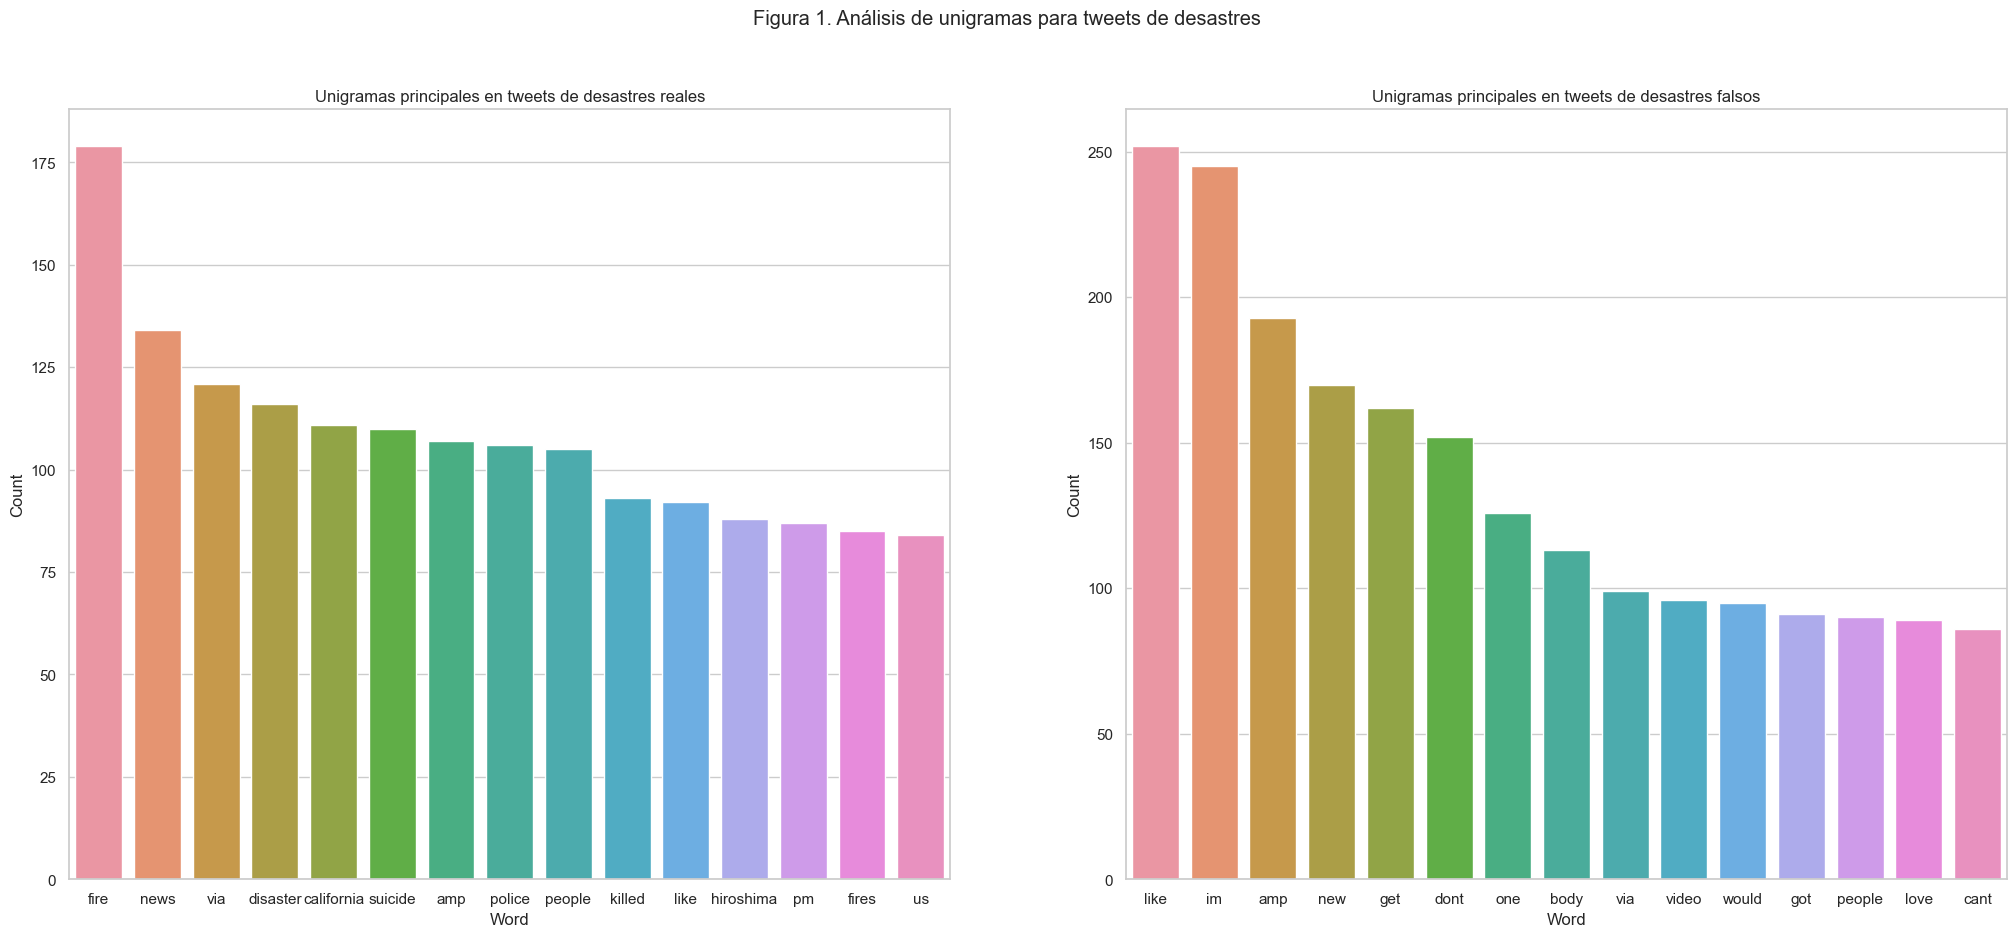

In [58]:
# Unigramas principales
fig, ax = plt.subplots(ncols=2)
sns.barplot(x=dfs[0].Word.head(15), y=dfs[0].Count.head(15), ax=ax[0])
sns.barplot(x=dfs[1].Word.head(15), y=dfs[1].Count.head(15), ax=ax[1])
ax[0].set_title('Unigramas principales en tweets de desastres reales')
ax[1].set_title('Unigramas principales en tweets de desastres falsos')
fig.suptitle('Figura 1. Análisis de unigramas para tweets de desastres')

Text(0.5, 0.98, 'Figura 2. Análisis de bigramas para tweets de desastres')

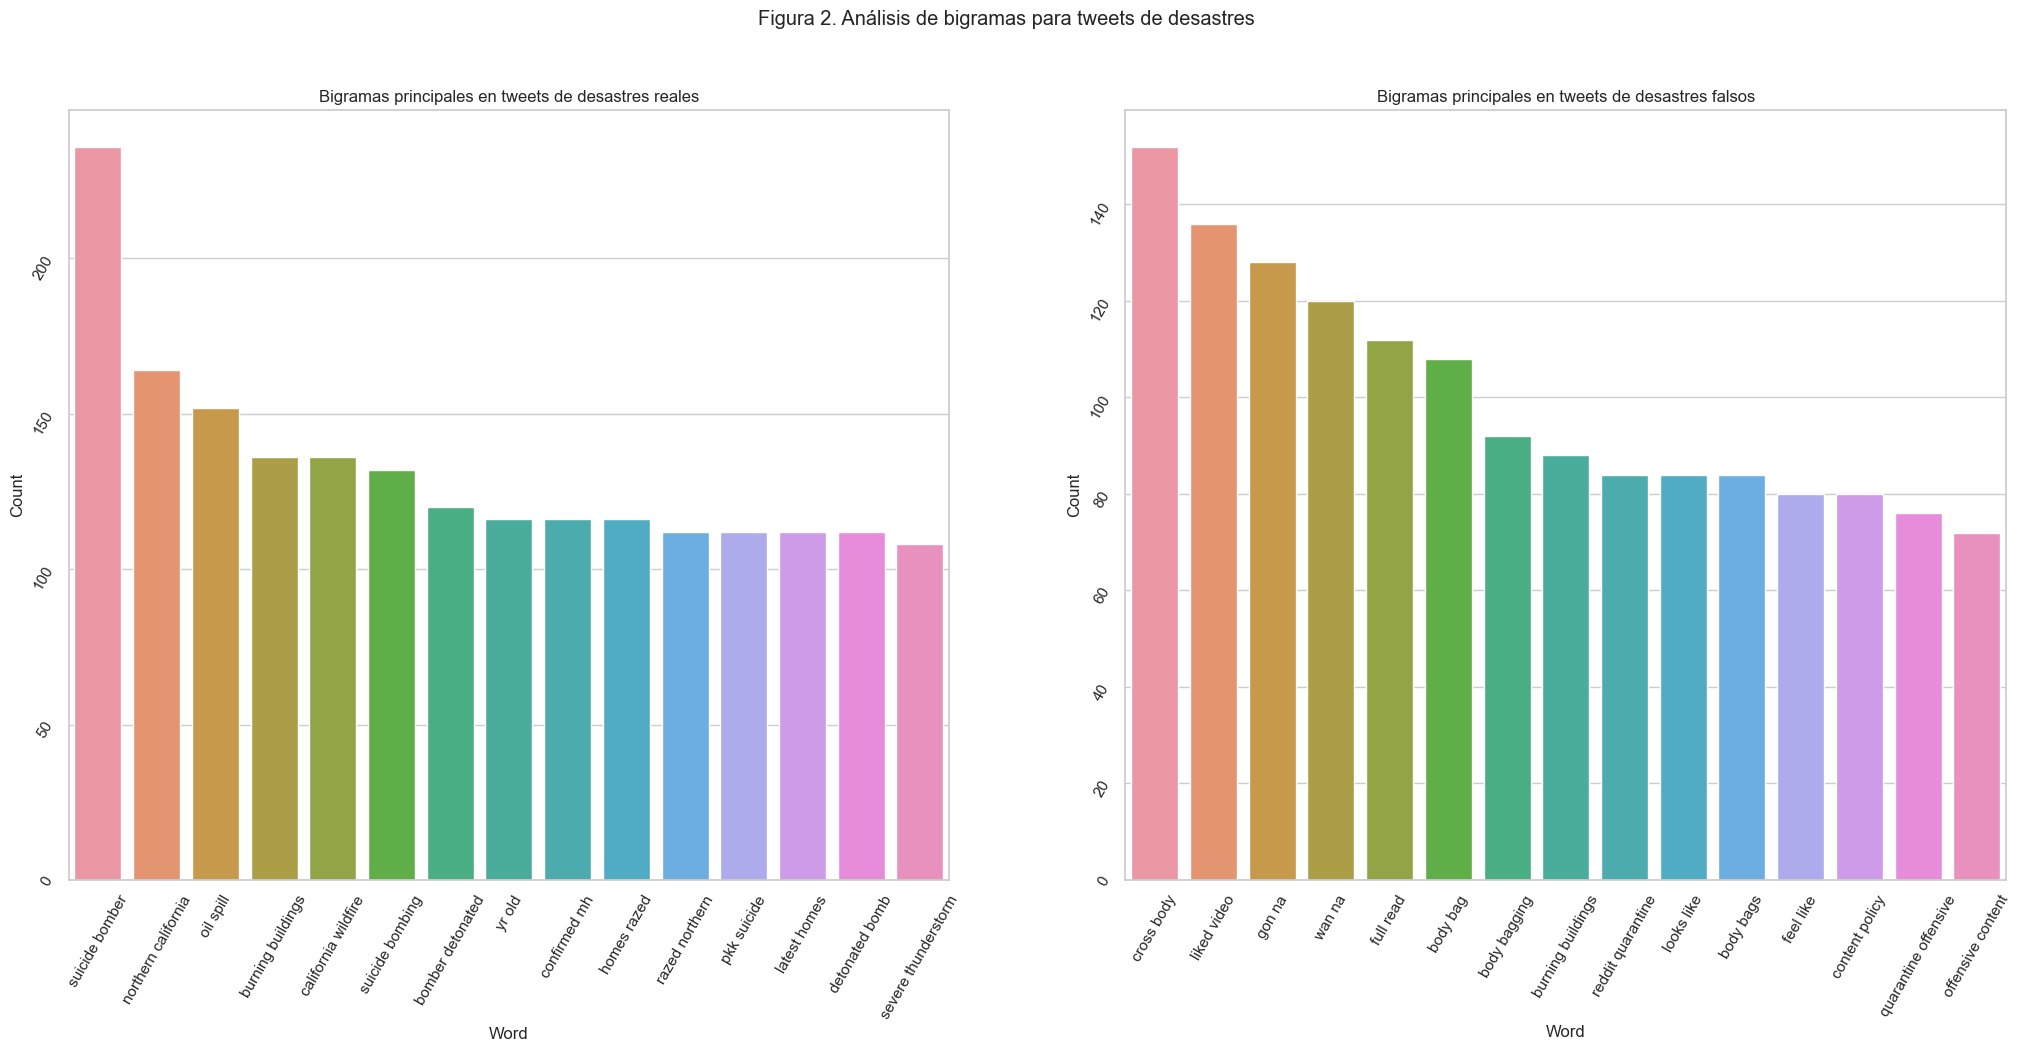

In [54]:
# Bigramas principales
fig, ax = plt.subplots(ncols=2)
sns.barplot(x=dfs[2].Word.head(15), y=dfs[2].Count.head(15), ax=ax[0])
ax[0].tick_params(labelrotation=60)
sns.barplot(x=dfs[3].Word.head(15), y=dfs[3].Count.head(15), ax=ax[1])
ax[1].tick_params(labelrotation=60)
ax[0].set_title('Bigramas principales en tweets de desastres reales')
ax[1].set_title('Bigramas principales en tweets de desastres falsos')
fig.suptitle('Figura 2. Análisis de bigramas para tweets de desastres')

Tal como se puede observar en las figuras anteriores, en los unigramas se puede observar que varios de los que se encuentran en los desastres categorizados como reales a su vez, también se encuentran en los clasificados como no reales, tal como *like, via* y *amp*. Por su lado, haciendo un análisis de bigramas, esto permite conocer a más detalle el contexto del tweet. En este caso se puede observar que para los desastres categorizados como reales, se tienen más bigramas relacionados con informar sobre un accidente como *oil spill* o sobre incendios, a diferencia de los bigramas obtenidos de los tweets que no hacen referencia a un desastre natural.

Por su parte, para el modelo de clasificación que se busca desarrollar, las palabras que pueden tener una mayor influencia son aquellas que hacen referencia a un sentimiento (como *love*, *like*, *offensive*), ya que estas palabras permiten obtener a manera general las emociones expresadas en el tweet.

### ¿Qué palabras se repiten más en cada una de las categorías?
Al observar la *figura 1* se nota que las 6 palabras más repetidas para el caso de desastres reales son:
- fire
- news
- via
- disaster
- california
- suicide
A su vez, en la misma figura se pueden observar las palabras más repetidas para aquellos tweets que no hacían referencia a un desastre, dentro de estas destacan:
- like
- im
- amp
- new
- get
- dont

### Visualización de frecuencia mediante una nube de palabras
Hacer una nube de palabras para visualizar las que aparecen con más frecuencia

In [55]:
# Referencia https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python Autor: HeadAndTail

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud.recolor(colormap= 'Blues' , random_state=17), alpha=0.98)
    plt.show()


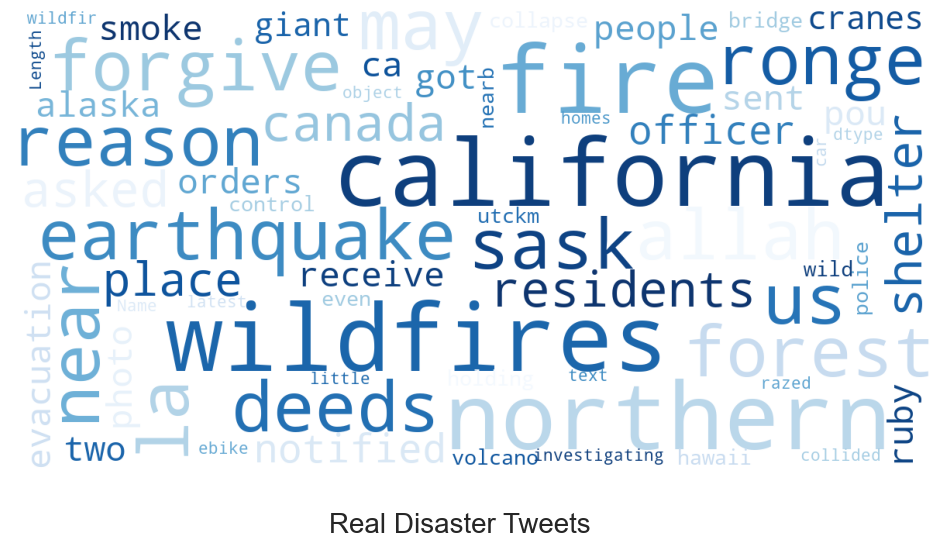

In [59]:
show_wordcloud(real_disaster, title = 'Real Disaster Tweets')

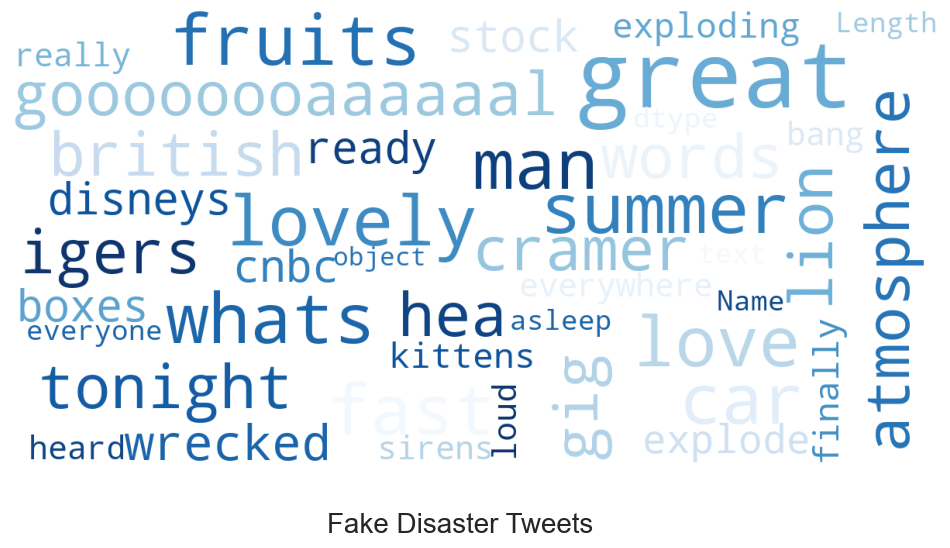

In [60]:
show_wordcloud(fake_disaster, title = 'Fake Disaster Tweets')

Como se puede observar en la nube de palabras para el caso de los tweets que tienen que ver con un desastre real, las palabras que más se repiten son: fire, california, earthquake, wildfires, etc. En el caso de la nube de palabras de los tweets que no tienen que ver con un desastre natural son: summer, lovely, hea, fruits, man, etc. Estas palabras se pueden observar de igual forma como las más frecuentes en las gráficas de frecuencia que se hicieron en el apartado anterior.

### Discutir sobre las palabras que tienen presencia en todas las categorías.

Text(0.5, 1.0, 'Figura 3. Presencia de palabras en ambas categorías de tweets')

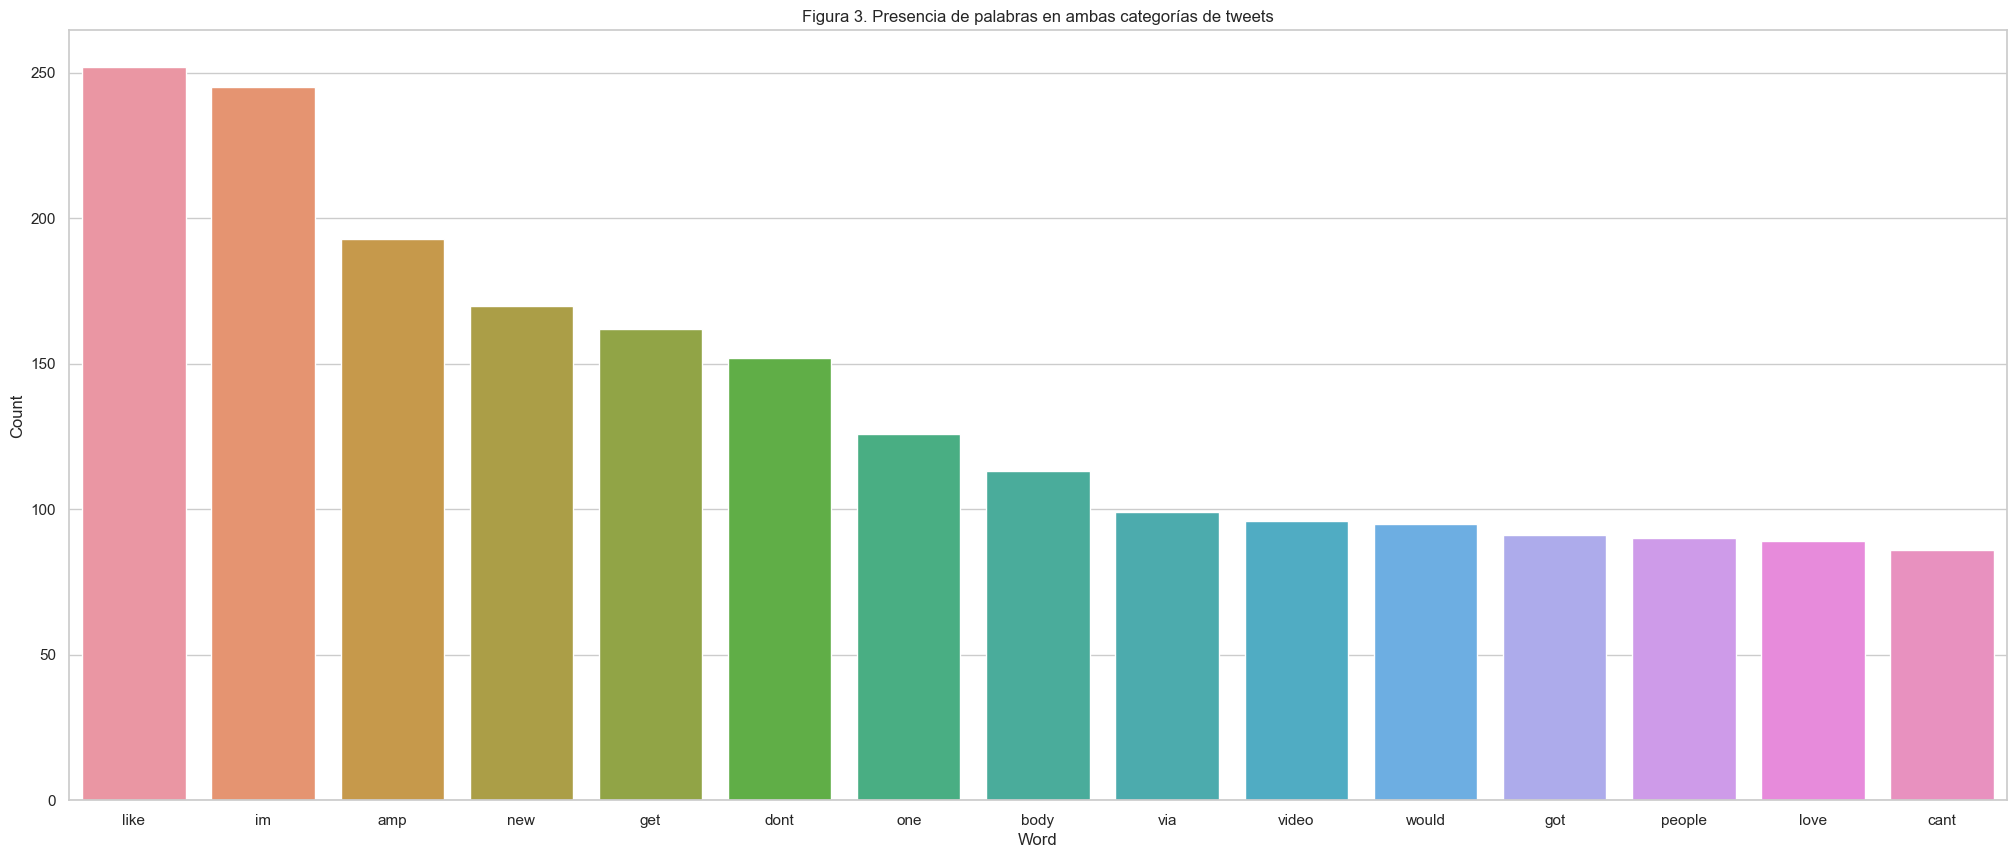

In [67]:
duplicates = dfs[1].assign(Isin=dfs[1].Word.isin(dfs[0].Word).astype(int))
sns.barplot(x=duplicates.loc[duplicates['Isin'] == 1].Word.head(15), y=duplicates.loc[duplicates['Isin'] == 1].Count.head(15))
plt.title('Figura 3. Presencia de palabras en ambas categorías de tweets')

En la **figura 3** se muestra la presencia de palabras en los tweets dentro del conjunto de datos proveídos para análisis. Algo interesante a notar es que tanto la palabra *like* como *im* son de las más repetidas en ambos grupos. Incluso *likes* es la palabra con más frecuente en los tweets que no tiene nada que ver con desastres y en el caso de los tweets que están relacionados con un desastre, esta se encuentra en el puesto 11. A su vez, entre las palabras más frecuentes se tiene *amp* que hace referencia a *amplifier* que es cuando proveen más contexto sobre algún tema específico.

### Determinar las palabras positivas, negativas o neutras
Clasificación de las palabras en positivas, negativas y neutrales. Explicación de las fuentes de datos o diccionarios utilizados.
Para la clasificación de las palabras en cada tweet, primero se separó el tweet en palabras (básicamente en unigramas), seguido a esto, se utilizó el módulo *Sentiment Analysis* de la librería *Textblob*. Mediante este módulo es posible obtener la polaridad de las palabras, esto en parte mediante el uso de la base de datos léxica *Wordnet*.

In [88]:
# Separación de tweets por palabras
tweets: list[str] = data[data.target == 1].text.apply(lambda s: nltk.word_tokenize(s))
frequency = nltk.FreqDist(list(itertools.chain(*tweets)))
unigrams = pd.DataFrame([[key, frequency[key]] for key in frequency.keys()], columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
unigrams

,Word,Count
8,fire,179
331,news,134
360,via,121
45,disaster,116
26,california,111
...,...,...
4037,vantage,1
4033,brewing,1
4032,unreal,1
4031,stormlike,1


In [89]:
# Cálculo de polaridad para las palabras presentes en los tweets
unigrams['polarity'] = unigrams['Word'].apply(lambda s: TextBlob(s).sentiment.polarity)
unigrams.sort_values(by='Count', ascending=False)

,Word,Count,polarity
8,fire,179,0.0
331,news,134,0.0
360,via,121,0.0
45,disaster,116,0.0
26,california,111,0.0
...,...,...,...
6366,benefits,1,0.0
6362,whereas,1,0.0
7566,bings,1,0.0
6329,subs,1,0.0


In [91]:
# Clasificación de las palabras con base en la polaridad obtenida
positivity = unigrams[unigrams.polarity > 0]
negative = unigrams[unigrams.polarity < 0]
neutral = unigrams[unigrams.polarity == 0]

In [99]:
print('Palabras positivas')
display(positivity[['Word', 'polarity']].sort_values(by='polarity', ascending=False).head(10))
print('Palabras negativas')
display(negative[['Word', 'polarity']].sort_values(by='polarity', ascending=True).head(10))
print('Palabras neutras')
neutral[['Word', 'polarity']].head(10)

Palabras positivas


,Word,polarity
2930,greatest,1.00
1706,best,1.00
1611,legendary,1.00
4740,excellent,1.00
3164,perfect,1.00
4992,awesome,1.00
1935,incredible,0.90
4925,incredibly,0.90
1783,beautiful,0.85
3966,fly,0.80


Palabras negativas


,Word,polarity
1112,terrible,-1.0
2386,awful,-1.0
224,horrible,-1.0
1571,worst,-1.0
5032,shocking,-1.0
1704,disgusting,-1.0
2053,evil,-1.0
809,horrific,-1.0
2335,terrifying,-1.0
1980,insane,-1.0


Palabras neutras


,Word,polarity
8,fire,0.0
331,news,0.0
360,via,0.0
45,disaster,0.0
26,california,0.0
804,suicide,0.0
443,amp,0.0
125,police,0.0
23,people,0.0
605,like,0.0


# Clasificación de Tweets
Teniendo en cuenta la cantidad de palabras positivas y negativas del tweet determine qué tan positivo, negativo o neutral es el mismo.
Para poder determinar qué tan positivo, negativo o neutral es un Tweet, se hizo uso de la librería *NLTK* específicamente del módulo *sentiment.vader*. *VADER* es un analizador de sentimientos léxico basado en reglas especialmente utilizado en mensajes de redes sociales (lo cual lo hace perfecto en este caso, ya que son tweets). Una de las principales ventajas de *VADER* es que sus cálculos de polaridad están realizados con base a 10 anotadores humanos, lo cual lo hace mucho más preciso que otros analizadores.

In [128]:
sid = SentimentIntensityAnalyzer()
data['negativity'] = data['text'].apply(lambda s: sid.polarity_scores(s)['neg'])
data['neutrality'] = data['text'].apply(lambda s: sid.polarity_scores(s)['neu'])
data['positivity'] = data['text'].apply(lambda s: sid.polarity_scores(s)['pos'])
data['polarity'] = data['text'].apply(lambda s: sid.polarity_scores(s)['compound'])
data[['text', 'negativity', 'neutrality', 'positivity', 'polarity']].head()

,text,negativity,neutrality,positivity,polarity
0,deeds reason earthquake may allah forgive us,0.000,0.741,0.259,0.2732
1,forest fire near la ronge sask canada,0.286,0.714,0.000,-0.3400
2,residents asked shelter place notified officer...,0.000,1.000,0.000,0.0000
3,people receive wildfires evacuation orders ca...,0.000,1.000,0.000,0.0000
4,got sent photo ruby alaska smoke wildfires pou...,0.000,1.000,0.000,0.0000


### ¿Cuáles son los 10 tweets más negativos?¿En qué categoría están?
Como se puede observar en la **figura 4** los 10 tweets más negativos en su mayoría pertenecen al grupo de tweets que hacen referencia a un desatre, ya que de los 10 tweets, 8 de estos pertenecen a un desastre real.

,text,negativity,target,polarity
7472,wreck wreck wreck wreck wreck wreck wreck wrec...,1.000,0,-0.9879
6411,suicide bomber kills saudi security site mosq...,0.681,1,-0.9623
6393,th day since jul nigeria suicide bomb attack...,0.645,1,-0.9595
6407,killed sarabia mosque suicide bombinga suicid...,0.673,1,-0.9552
472,illegal alien released obamadhs times charged...,0.634,1,-0.9538
1540,bomb crash loot riot emergency pipe bomb nucle...,0.566,1,-0.9524
6930,prez mr president biggest terrorist trouble m...,0.649,1,-0.9493
2932,lake sees dead fishme poor little guy wonder h...,0.673,0,-0.9477
4547,udhampur terror attack militants attack police...,0.711,1,-0.9451
4561,udhampur terror attack militants attack police...,0.711,1,-0.9451


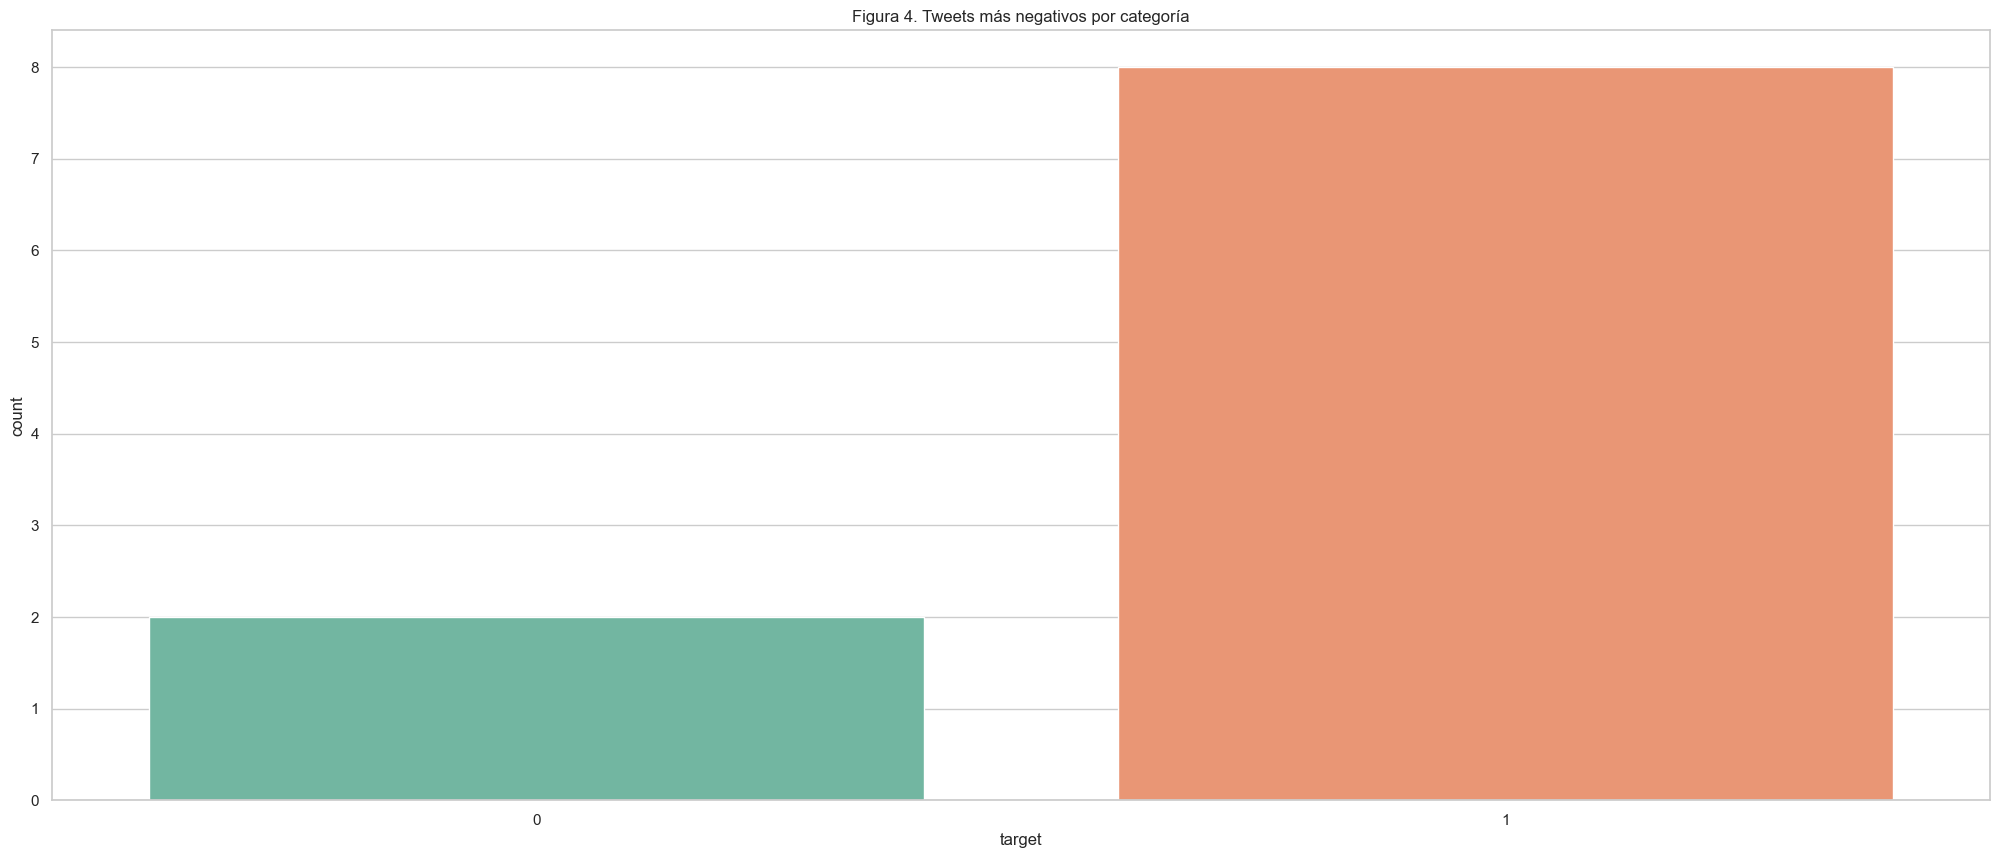

In [132]:
negative_tweets = data[['text', 'negativity', 'target', 'polarity']].sort_values(by='polarity').head(10)
display(negative_tweets)
sns.countplot(data=negative_tweets, x="target")
plt.title('Figura 4. Tweets más negativos por categoría')
del negative_tweets

### ¿Cuáles son los 10 tweets más positivos? ¿En qué categoría están?
Como se puede notar en la **figura 5** la mayoría de los tweets más positivos hacen referencia a desastres "falsos" o tweets que no hablan sobre un desastre, ya que se tienen 9 tweets de este tipo, y dejando únicamente 1 tweet perteneciente a desastres.

,text,positivity,target,polarity
6992,check want twister tickets vip experience see ...,0.724,0,0.9682
3163,enjoyed show today great fun emergency non ev...,0.697,0,0.9423
3382,enjoyed show today great fun emergency non ev...,0.697,0,0.9423
6292,todays storm pass let tomorrows light greet ki...,0.611,1,0.9403
7182,nothing wrong lethal weapon series great yes ...,0.793,0,0.9365
2238,meditationbymsg ppl got method meditation amp...,0.631,0,0.9287
7449,wounds kissed someone doesnt see disasters sou...,0.628,0,0.9263
6295,free ebay sniping rt lumbar extender back str...,0.617,0,0.9260
6560,yeah survived seasons movies lets hope g...,0.780,0,0.9217
1856,love love love remember first crush,0.778,0,0.9186


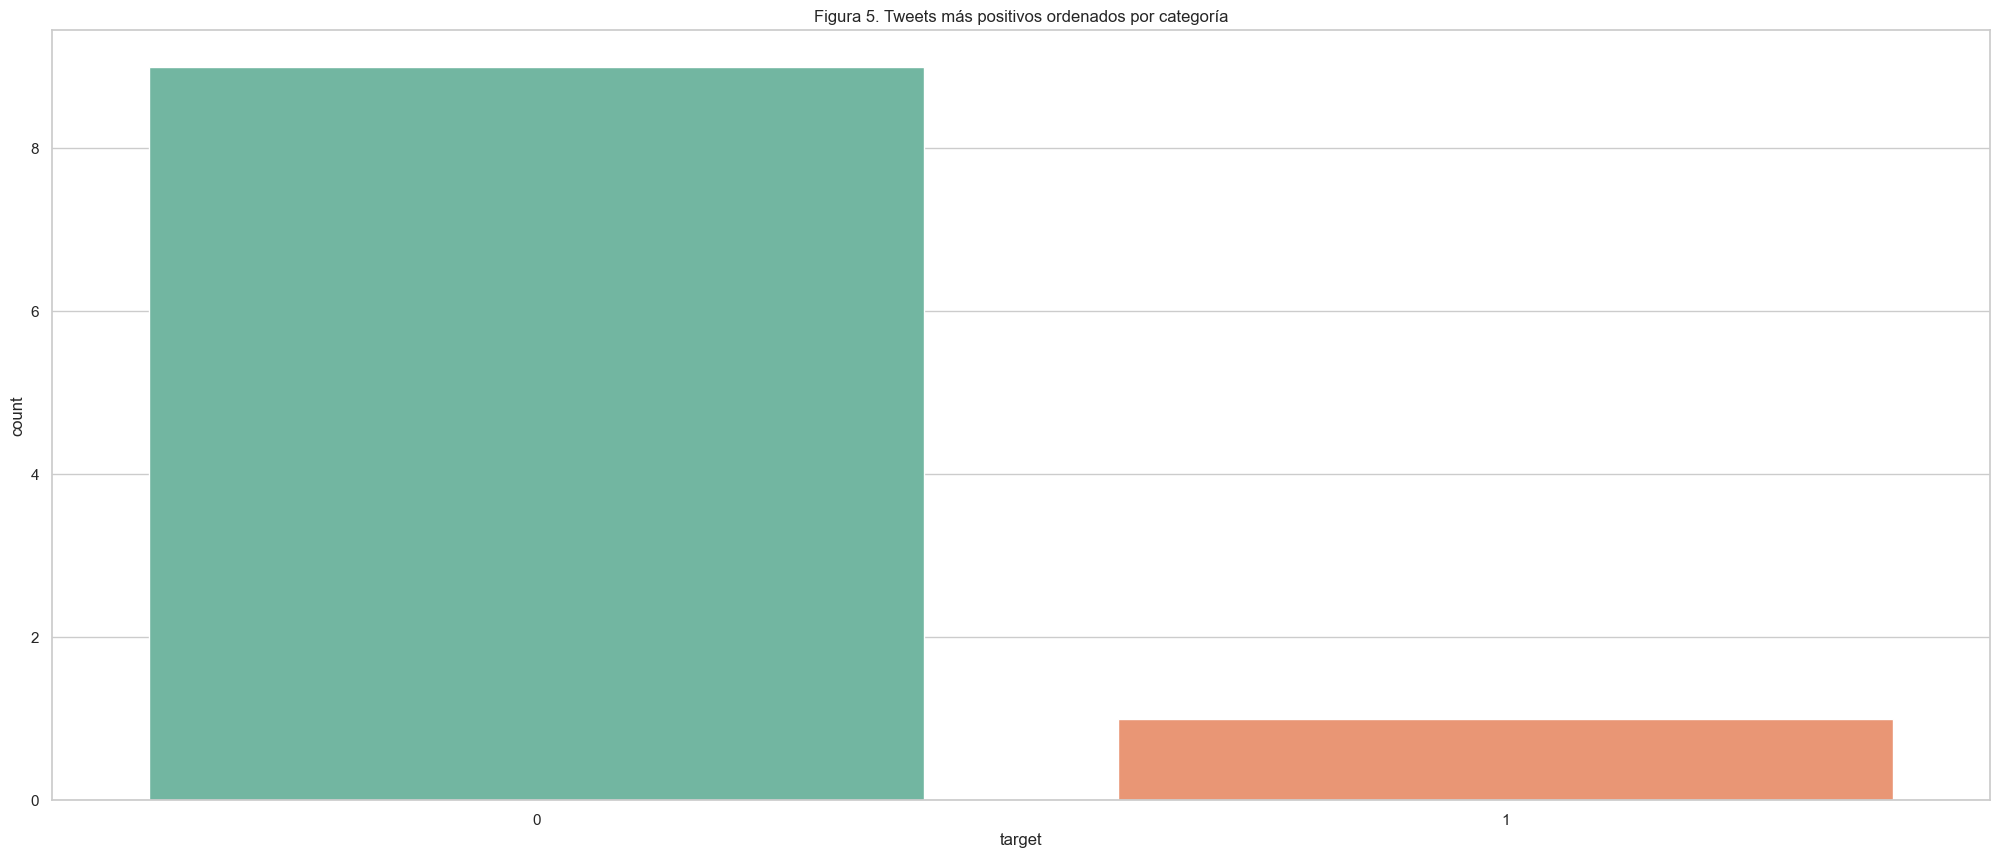

In [135]:
positive_tweets = data[['text', 'positivity', 'target', 'polarity']].sort_values(by='polarity', ascending=False).head(10)
display(positive_tweets)
sns.countplot(data=positive_tweets, x="target")
plt.title('Figura 5. Tweets más positivos ordenados por categoría')
del positive_tweets

### ¿Son los tweets de la categoría que indica que habla de un desastre real más negativos que los de la otra categoría?
Tal y como se muestra en las figuras anteriores, la mayoría de los tweets negativos (de hecho un ..%) son tweets que hacen referencia a desastres reales. Esto está asociado con el hecho de que un desastre es un hecho que afecta **negativamente** a la vida o al medio ambiente, de hecho, la RAE define desastre como una "desgracia grande, suceso infeliz y lamentable". Con esto en mente, es esperado que los tweets negativos en su mayoría estén relacionados con desastres, ya que son hechos que alteran el funcionamiento de la tierra y afectan emocionalmente tanto a aquellos que lo viven como aquellos que empatizan con los afectados.

### ¿La inclusión de la negatividad en el conjunto de datos mejoró los resultados del modelo de clasificación?